<a href="https://colab.research.google.com/github/casualcomputer/statistics_applications/blob/main/policy_effect_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Difference-in-Difference estimation: estimate of policy impact

# How I approach the problem

We want to measure the impact of the rebate policy on electric vehicle registrations, particularly in Quebec.

Train of thoughts:

1. a natural thing to try is just test the difference between EV registrations pre and post rebate. However, one should be cautious that a test like the t-test is not applicable, because it assumes that the errors are i.i.d. under a simple linear model (assume that's the data-generating process of the data). Upon checking, these errors are most likely auto-correlated.

2. one would also try the difference-in-difference model under the linear regression framework. It's important to pay attention to the assumptions like parallel trends.
- if we only have quebec data before and after policy, then we are back to case 1.
- if possible, we should include data points from other provinces. One may ask, what's the point though if the focus is only quebec. after all, provinces have intrinsitincally different characteristics that drive consumer behaviours in EV purchase.
  
  -- Yes, but there are ways to adjust the difference in the effect of policy estimation, between provinces that could contribute to different EV registration levels. We use techniques like matching to accountant for the difference in provinces' attributes that may drive purchase behaviours, such as disposable income, availability of charging stations (count, wait time, geospatial vicinity), modes of commutes, rural and urban populations. To apply the matching technique in practice, we need to include more variables for each provinces that could affect vehicle registrations.

  -- In addition, one can introduce fixed effects at the province level to account for the variances at the province level. If you look at the data visaulization section in the notebook, there is a significant amount of variance in each province that need to be considered when modeling the impact of the policy on EV purchase within the province. Note, it will be useful to explain how non-quebec data actually improve model fit, while allowing the isolate of the policy impact on Quebec only.

  -- We can also apply time series/state-space model in the DiD estimation. Other models we could try is "unbiased" machine learning techniques in Python to account for time-varying treatment effect in staggered DiD-treatment: https://arxiv.org/pdf/2310.11962. In our setup, rebates are staggered as various provincial rebates were and will be introduced at different time.

  -- Interestingly, we can also model this process with staggered difference-in-difference model, knowing that Ontario also introduced its provincial rebate program to reduce the cost of EV purchase. Keep in mind that the rebate amount and specific terms in Quebec are different from those in Ontairio.

  -- what techniques allow us to address confounding variables that could influence experimental units in both treatment and control? For example, co-founding variables such as provincial infrastructure could be confounding, as they impact the purchase/thus registration decisions of EV.


  3. Some data limitations: I have not considered PHEV (filtered out of this dataset), federal rebates programs, and other provincial programs outside of Quebec and Ontario. Later, one could re-introduce additional treatments.

  4. Some definition problems: it's unclear to me how a make and model is classified into a specific vehicle type, including "passenger vehicles", "multi-purpose", "pickup", and "vans". For scrutiny, go to the StatsCan's website and read its data sources and methodologies: https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2010002401

  More ideas and questions:

  - rebates in different provinces are similar for EV purchase, but the specific terms and claim process are different, such as the rebate amount, specific terms for qualification, and different process to receive rebates (e.g. through non-refundable tax credits). we should account for these factors of the rebate process, as they could have signifcant extent to drive purcahse decisions.

  - how do staggered DiD account for the treatment differences (e.g. different provinces implement different policies)? rebate claim processes are slightly different (e.g. rebate may require application and wait time, some go through tax returns, others may be applied directly through purchase price). what are some limitations. https://www.hbs.edu/ris/Publication%20Files/21-112_8a5a4ab3-b9e7-447d-a0fe-a504b3890fb9.pdf

  - it's unclear why SVM and DNN cannot be directly applied to estimate the effect of the treatments. maybe setup a torch library, that could be my masters degree.. lol




**Basic equation:** Registrations$_{i}$ = $\beta_0$+ $\beta_1$* Indicator(is quebec)+ $\beta_2$* Indicator(after policy in effect)+ $\beta_3$* Indicator(is quebec)* Indicator(after policy in effect)

1. Before policy in effect:
  
  * quebec: $\beta_0$ + $\beta_1$
  * non-quebec provinces: $\beta_0$    
  * Here, the difference **provincial_delta_pre_policy** (Quebec vs. non-Quebec) is indeed represented by $\beta_1$, indicating how much higher or lower the registrations were in Quebec compared to non-Quebec before the policy.


2. After policy in effect:

  * quebec: $\beta_0$ + $\beta_1$ +$\beta_2$ +$\beta_3$
  * non-quebec provinces: $\beta_0$ +$\beta_2$
  * In this scenario, the **difference provincial_delta_after_policy** (Quebec vs. non-Quebec) becomes $\beta_1 + \beta_3$. This measures the combined effect of the inherent differences between Quebec and non-Quebec plus the additional impact of the policy in Quebec.

3. Interpretation of Coefficients:
* $\beta_1$ tells you how different Quebec was from non-Quebec in terms of vehicle registrations before the policy.
* $\beta_2$ tells you the effect of the policy across the board (assuming it applies in some form to all provinces).
* $\beta_3$ provides the incremental effect of the policy in Quebec, adjusting for the general policy effect.

Important things to consider:

1. policy may apply to different products (e.g. vehicles with different watts ratings) at different rebate levels

2. we are making the following statistical assumptions:

*   *consistency:* non-quebec group never received the policy rebates, quebec only received the rebate after the policy was put in effect.
*   *arrow-of-time:* future policy doesn't affect past outcomes, i.e., the cause (policy implementation) occurs before its effects (changes in sales).
*   *parallel trends:* in the absence of the rebate policy, Quebec and non-Quebec provinces would have experienced similar trends in sales over time



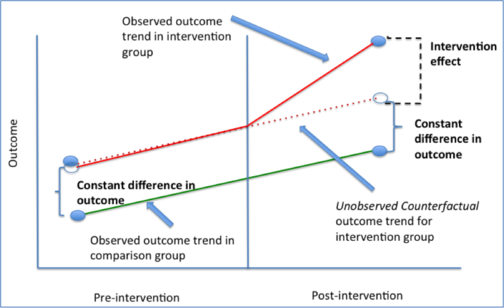

More literature: https://diff.healthpolicydatascience.org/

Picture: https://learncuriously.wordpress.com/2021/06/18/pre-post-analysis/

# Data Cleaning

In [3]:
install.packages("lubridate")
#install.packages("reactable")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [4]:
# Load the readr library
library(readr)

# Load the CSV data directly from the URL using read_csv
data <- read_csv("https://raw.githubusercontent.com/casualcomputer/statistics_applications/main/2010002401_databaseLoadingData.csv")

# View the first few rows of the dataframe to check the data
head(data)

Rows: 1450 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (11): REF_DATE, GEO, DGUID, Fuel type, Vehicle type, Statistics, UOM, SC...
dbl  (4): UOM_ID, SCALAR_ID, VALUE, DECIMALS
lgl  (2): SYMBOL, TERMINATED

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


REF_DATE,GEO,DGUID,Fuel type,Vehicle type,Statistics,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<lgl>,<lgl>,<dbl>
2017-01,Newfoundland and Labrador,2016A000210,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1271719105,2.4.1.1,NA,..,NA,NA,0
2017-04,Newfoundland and Labrador,2016A000210,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1271719105,2.4.1.1,NA,..,NA,NA,0
2017-07,Newfoundland and Labrador,2016A000210,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1271719105,2.4.1.1,NA,..,NA,NA,0
2017-10,Newfoundland and Labrador,2016A000210,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1271719105,2.4.1.1,NA,..,NA,NA,0
2018-01,Newfoundland and Labrador,2016A000210,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1271719105,2.4.1.1,NA,..,NA,NA,0
2018-04,Newfoundland and Labrador,2016A000210,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1271719105,2.4.1.1,NA,..,NA,NA,0


In [5]:
# Selecting columns by their indices
selected_data <- data[, c(1, 2, 4, 5,13)]

# Clean dates
library(lubridate)
selected_data$REF_DATE <- lubridate::as_date(ym(selected_data$REF_DATE))

# View the first few rows to confirm the change
head(selected_data)

# show unique values
unique(selected_data$GEO) #'Battery electric'
unique(selected_data$`Fuel type`) #'Battery electric'
unique(selected_data$`Vehicle type`) #'Total, vehicle type''Passenger cars''Pickup trucks''Multi-purpose vehicles''Vans'



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




REF_DATE,GEO,Fuel type,Vehicle type,VALUE
<date>,<chr>,<chr>,<chr>,<dbl>
2017-01-01,Newfoundland and Labrador,Battery electric,"Total, vehicle type",NA
2017-04-01,Newfoundland and Labrador,Battery electric,"Total, vehicle type",NA
2017-07-01,Newfoundland and Labrador,Battery electric,"Total, vehicle type",NA
2017-10-01,Newfoundland and Labrador,Battery electric,"Total, vehicle type",NA
2018-01-01,Newfoundland and Labrador,Battery electric,"Total, vehicle type",NA
2018-04-01,Newfoundland and Labrador,Battery electric,"Total, vehicle type",NA


[1] "Newfoundland and Labrador"           
 [2] "Prince Edward Island"                
 [3] "Nova Scotia"                         
 [4] "New Brunswick"                       
 [5] "Quebec"                              
 [6] "Ontario"                             
 [7] "Manitoba"                            
 [8] "Saskatchewan"                        
 [9] "Alberta"                             
[10] "British Columbia and the Territories"

[1] "Battery electric"

[1] "Total, vehicle type"    "Passenger cars"         "Pickup trucks"         
[4] "Multi-purpose vehicles" "Vans"

In [6]:
# Create indicators for DID setup
library(dplyr)
library(stringr)
df <- selected_data %>%
  mutate(is_quebec = case_when(
    str_detect(GEO, "Quebec") ~ 1,  # Detects 'Quebec' in the 'region' column
    TRUE ~ 0  # Default case, assigns 0 if not 'Quebec'
  ),
  after_policy = case_when(
    REF_DATE>=as.Date("2023-04-18") ~ 1,
    TRUE ~ 0
  ),
  ref_year = year(REF_DATE)
) %>%
  filter(VALUE!="NA")
names(df) = c("ref_date","province","fuel_type","vehicle_type","registrations","is_quebec","after_policy","ref_year")
head(df)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




ref_date,province,fuel_type,vehicle_type,registrations,is_quebec,after_policy,ref_year
<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
2017-01-01,Prince Edward Island,Battery electric,"Total, vehicle type",0,0,0,2017
2017-04-01,Prince Edward Island,Battery electric,"Total, vehicle type",0,0,0,2017
2017-07-01,Prince Edward Island,Battery electric,"Total, vehicle type",0,0,0,2017
2017-10-01,Prince Edward Island,Battery electric,"Total, vehicle type",0,0,0,2017
2018-01-01,Prince Edward Island,Battery electric,"Total, vehicle type",2,0,0,2018
2018-04-01,Prince Edward Island,Battery electric,"Total, vehicle type",3,0,0,2018


In [7]:
# create factors for visualization by facets
df$is_quebec <- factor(df$is_quebec, levels = c(0, 1), labels = c("Non-Quebec", "Quebec"))
df$after_policy <- factor(df$after_policy, levels = c(0, 1), labels = c("Before Policy", "After Policy"))

# dataframe with the total registrations
aggregated_df = df %>%
   filter(vehicle_type=="Total, vehicle type")
head(aggregated_df)

# dataframe with the registrations by vehicle types
df_vehicle_type = df %>%
   filter(vehicle_type!="Total, vehicle type")

ref_date,province,fuel_type,vehicle_type,registrations,is_quebec,after_policy,ref_year
<date>,<chr>,<chr>,<chr>,<dbl>,<fct>,<fct>,<dbl>
2017-01-01,Prince Edward Island,Battery electric,"Total, vehicle type",0,Non-Quebec,Before Policy,2017
2017-04-01,Prince Edward Island,Battery electric,"Total, vehicle type",0,Non-Quebec,Before Policy,2017
2017-07-01,Prince Edward Island,Battery electric,"Total, vehicle type",0,Non-Quebec,Before Policy,2017
2017-10-01,Prince Edward Island,Battery electric,"Total, vehicle type",0,Non-Quebec,Before Policy,2017
2018-01-01,Prince Edward Island,Battery electric,"Total, vehicle type",2,Non-Quebec,Before Policy,2018
2018-04-01,Prince Edward Island,Battery electric,"Total, vehicle type",3,Non-Quebec,Before Policy,2018


# Data visualization: Quebec vs. non-Quebec registrations before/after policy rebates

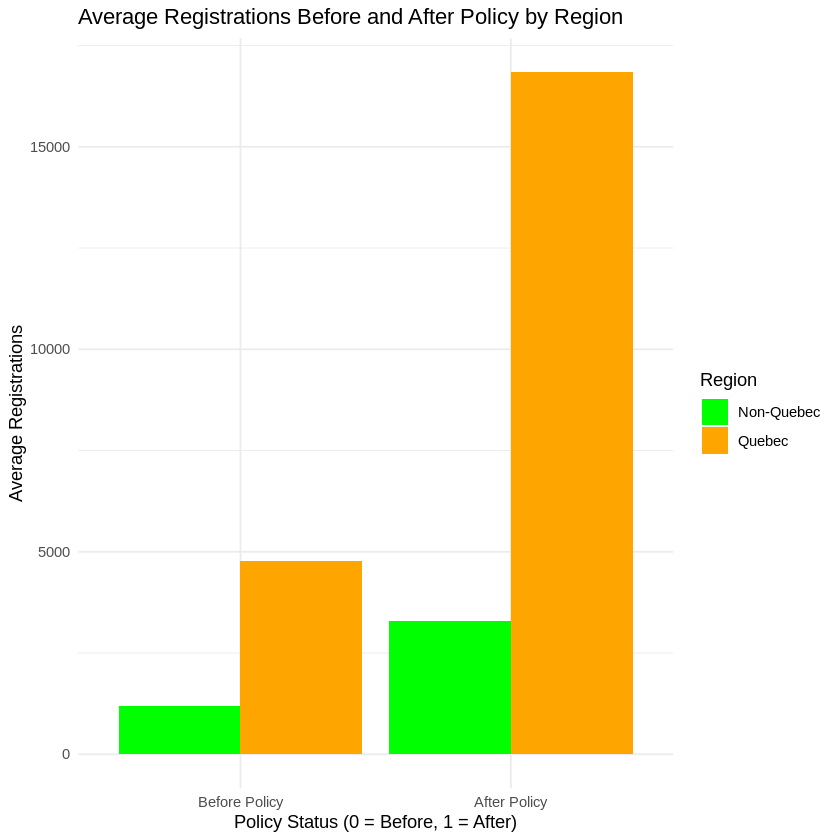

In [8]:
library(ggplot2)
# Create a grouped bar chart to compare sales before and after policy by region
ggplot(aggregated_df, aes(x = as.factor(after_policy), y = registrations, fill = as.factor(is_quebec))) +
  geom_bar(stat = "summary", fun = "mean", position = position_dodge()) +
  labs(title = "Average Registrations Before and After Policy by Region",
       x = "Policy Status (0 = Before, 1 = After)",
       y = "Average Registrations",
       fill = "Region") +
  scale_fill_manual(values = c("green", "orange"),
                    labels = c("Non-Quebec", "Quebec")) +
  theme_minimal()


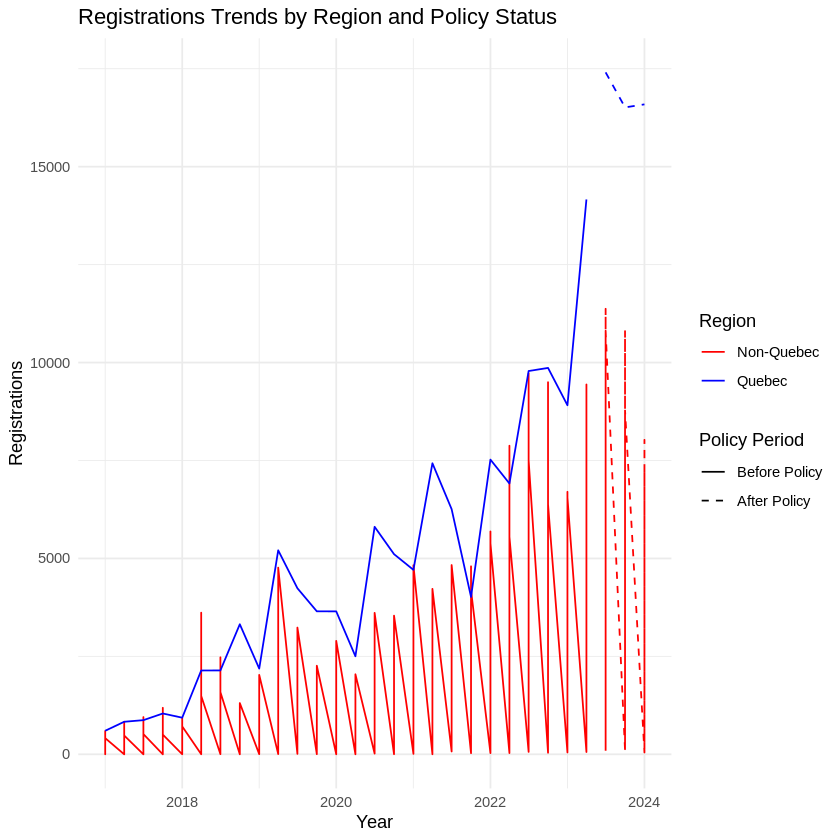

In [9]:
library(ggplot2)

# Convert is_quebec and after_policy to factors if they're not already
#aggregated_df$is_quebec <- factor(aggregated_df$is_quebec, levels = c(0, 1), labels = c("Non-Quebec", "Quebec"))
#aggregated_df$after_policy <- factor(aggregated_df$after_policy, levels = c(0, 1), labels = c("Before Policy", "After Policy"))

# Assuming aggregated_df is correctly set up and the necessary libraries are loaded
ggplot(aggregated_df, aes(x = ref_date, y = registrations, color = is_quebec, linetype = after_policy)) +
  geom_line() +  # Use line geometry to represent data trends over time
  labs(title = "Registrations Trends by Region and Policy Status",
       x = "Year",
       y = "Registrations",
       color = "Region",
       linetype = "Policy Period") +
  scale_color_manual(values = c("red","blue")) +  # Ensure colors are correctly assigned to factor levels
  scale_linetype_manual(values = c("solid",  "dashed")) +  # Ensure line types are correctly assigned
  theme_minimal()  # Use a minimalistic theme for a clean look


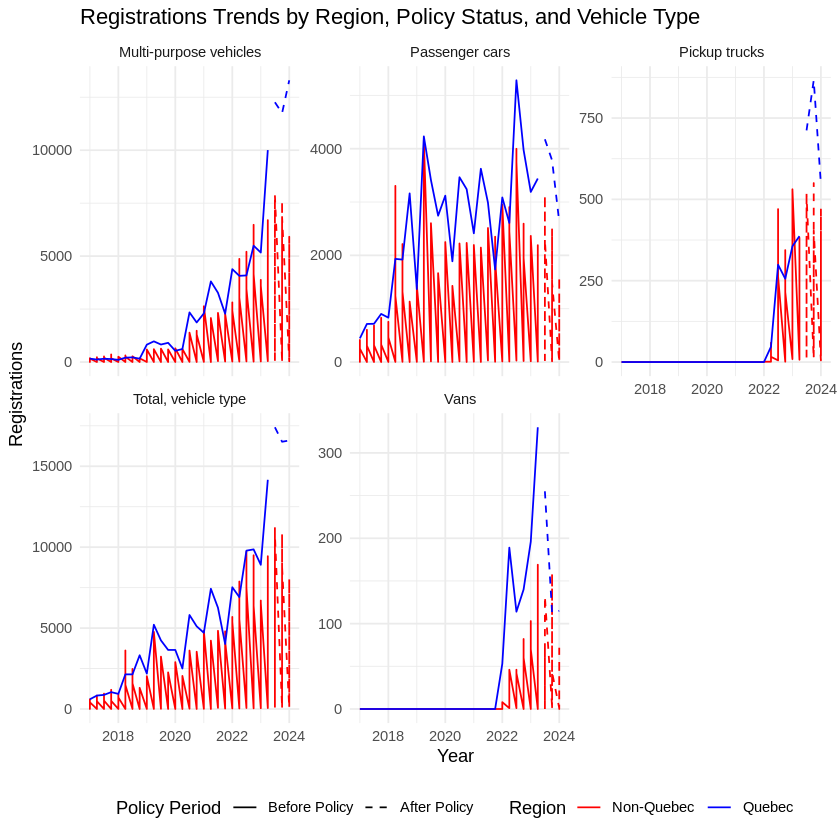

In [10]:
# Check levels of the factors
#print(unique(df$is_quebec))
#print(unique(df$after_policy))

# Create the plot with facets for each vehicle type
ggplot(df, aes(x = ref_date, y = registrations, color = is_quebec, linetype = after_policy)) +
  geom_line() +  # Use line geometry to show trends
  facet_wrap(~ vehicle_type, scales = "free_y") +  # Create separate plots for each vehicle type
  labs(title = "Registrations Trends by Region, Policy Status, and Vehicle Type",
       x = "Year",
       y = "Registrations",
       color = "Region",
       linetype = "Policy Period") +
  scale_color_manual(values = c("red", "blue")) +  # Customize colors for clarity
  scale_linetype_manual(values = c("solid", "dashed")) +  # Customize line types for before and after policy
  theme_minimal() +  # Use a minimal theme for a clean look
  theme(legend.position = "bottom")  # Position the legend at the bottom for better accessibility

`geom_smooth()` using formula = 'y ~ x'


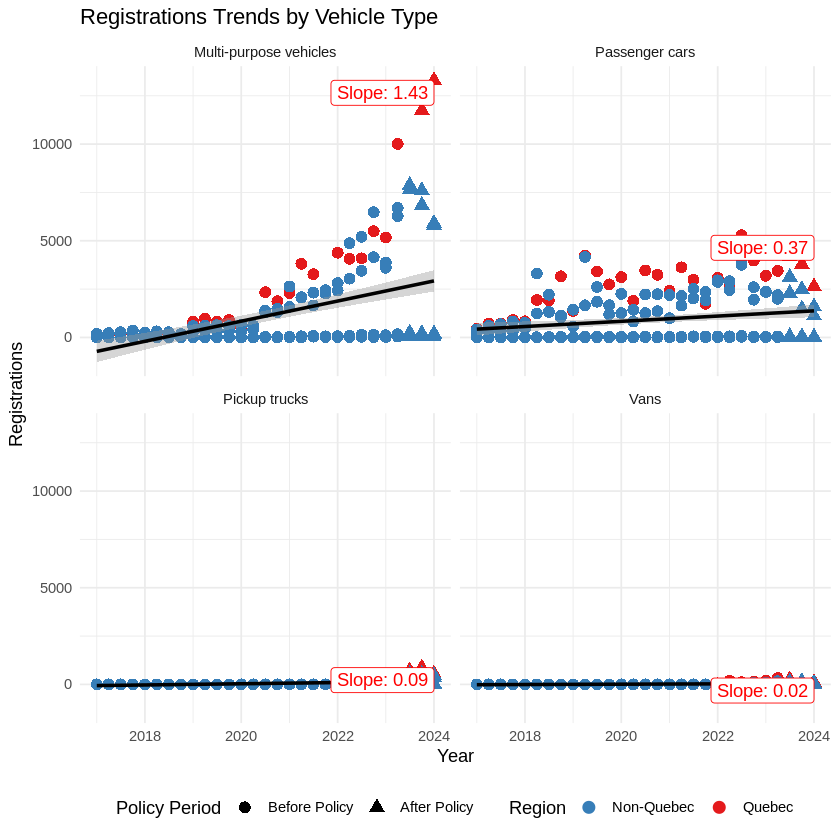

In [11]:
# Calculate slopes and prepare data for labels
slope_data <- df_vehicle_type %>%
  group_by(vehicle_type) %>%
  do({
    mod <- lm(registrations ~ ref_date, data = .)
    data.frame(
      slope = coef(mod)[["ref_date"]],
      label_x = max(.$ref_date),  # Position at the latest date
      label_y = max(.$registrations)  # Position at the maximum registrations
    )
  }) %>%
  ungroup()

# Merge the slope data back correctly
df_vehicle_type_vis <- df_vehicle_type %>%
  left_join(slope_data, by = "vehicle_type")

# Generate the plot with accurate slopes
ggplot(df_vehicle_type_vis, aes(x = ref_date, y = registrations, color = is_quebec)) +
  geom_point(aes(shape = after_policy), size = 3) +
  geom_smooth(method = "lm", aes(group = vehicle_type), color = "black", se = TRUE) +
  geom_label(data = slope_data, aes(x = label_x, y = label_y, label = sprintf("Slope: %.2f", slope)),
             hjust = 1, vjust = 1, color = "red", show.legend = FALSE) +
  facet_wrap(~ vehicle_type, scales = "fixed") +
  labs(title = "Registrations Trends by Vehicle Type",
       x = "Year", y = "Registrations", color = "Region", shape = "Policy Period") +
  scale_color_manual(values = c("Non-Quebec" = "#377eb8", "Quebec" = "#e41a1c")) +
  scale_shape_manual(values = c("Before Policy" = 16, "After Policy" = 17)) +
  theme_minimal() +
  theme(legend.position = "bottom")


province,slope,label_x,label_y
<chr>,<dbl>,<date>,<dbl>
British Columbia and the Territories,0.854746611,2024-01-01,7876
Manitoba,0.026558072,2024-01-01,237
New Brunswick,0.026084186,2024-01-01,208
Ontario,0.976510320,2024-01-01,7644
Prince Edward Island,0.007713773,2024-01-01,73
Quebec,1.424442240,2024-01-01,13300


`geom_smooth()` using formula = 'y ~ x'


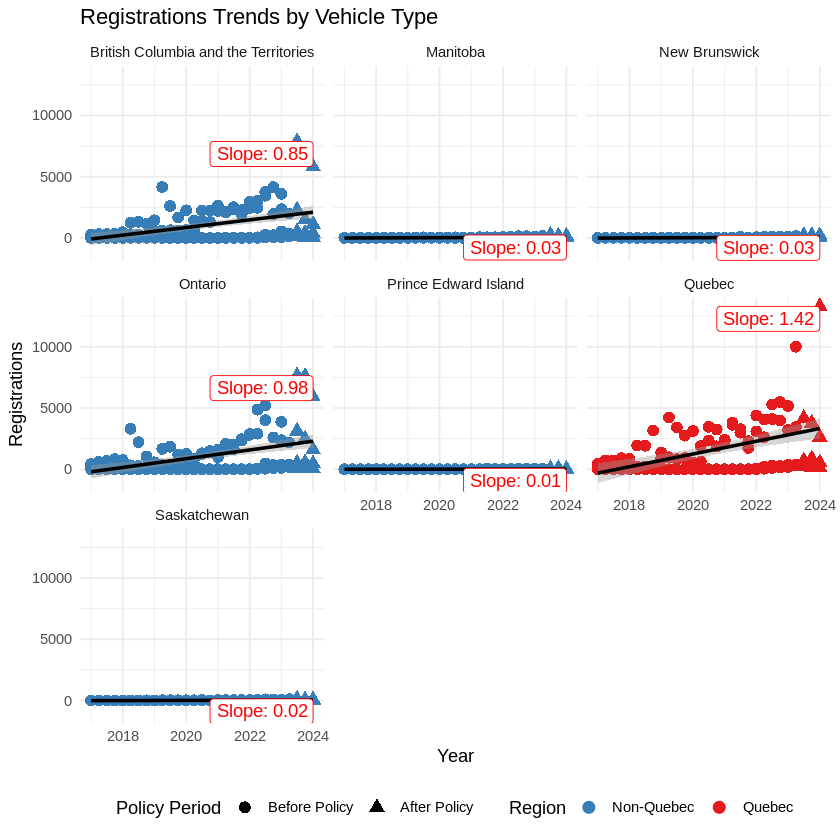

In [12]:
# Calculate slopes and prepare data for labels
slope_data <- df_vehicle_type %>%
  group_by(province) %>%
  do({
    mod <- lm(registrations ~ ref_date, data = .)
    data.frame(
      slope = coef(mod)[["ref_date"]],
      label_x = max(.$ref_date),  # Position at the latest date
      label_y = max(.$registrations)  # Position at the maximum registrations
    )
  }) %>%
  ungroup()
head(slope_data)

# Merge the slope data back correctly
df_vehicle_type_vis <- df_vehicle_type %>%
  left_join(slope_data, by = c("province"="province"))

# Generate the plot with accurate slopes
ggplot(df_vehicle_type_vis, aes(x = ref_date, y = registrations, color = is_quebec)) +
  geom_point(aes(shape = after_policy), size = 3) +
  geom_smooth(method = "lm", aes(group = province), color = "black", se = TRUE) +
  geom_label(data = slope_data, aes(x = label_x, y = label_y, label = sprintf("Slope: %.2f", slope)),
             hjust = 1, vjust = 1, color = "red", show.legend = FALSE) +
  facet_wrap(~ province, scales = "fixed") +
  labs(title = "Registrations Trends by Vehicle Type",
       x = "Year", y = "Registrations", color = "Region", shape = "Policy Period") +
  scale_color_manual(values = c("Non-Quebec" = "#377eb8", "Quebec" = "#e41a1c")) +
  scale_shape_manual(values = c("Before Policy" = 16, "After Policy" = 17)) +
  theme_minimal() +
  theme(legend.position = "bottom")


# Basic DID model: modeling total registrations by province

In [13]:
# Assuming `df` is your DataFrame with `sales` as the outcome, `year` for time, `is_quebec` as a group indicator, and `after_policy` as the post-policy period indicator

# Basic DiD model
basic_did <- lm(registrations ~ is_quebec * after_policy, data = aggregated_df) #beta3: 3982.86
summary(basic_did)

# Log basic DiD model loged
log_basic_did <- lm(log(registrations+1) ~ is_quebec * after_policy, data = aggregated_df) #beta3: 3982.86
summary(log_basic_did)


Call:
lm(formula = registrations ~ is_quebec * after_policy, data = aggregated_df)

Residuals:
   Min     1Q Median     3Q    Max 
 -4160  -1180  -1113    424   9401 

Coefficients:
                                         Estimate Std. Error t value Pr(>|t|)
(Intercept)                                1185.3      212.6   5.575 8.00e-08
is_quebecQuebec                            3576.2      562.5   6.357 1.38e-09
after_policyAfter Policy                   2118.0      661.1   3.204  0.00158
is_quebecQuebec:after_policyAfter Policy   9957.1     1749.0   5.693 4.43e-08
                                            
(Intercept)                              ***
is_quebecQuebec                          ***
after_policyAfter Policy                 ** 
is_quebecQuebec:after_policyAfter Policy ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2656 on 199 degrees of freedom
Multiple R-squared:  0.4141,	Adjusted R-squared:  0.4053 
F-statistic: 46.89 o


Call:
lm(formula = log(registrations + 1) ~ is_quebec * after_policy, 
    data = aggregated_df)

Residuals:
   Min     1Q Median     3Q    Max 
-4.650 -1.575 -0.293  2.085  4.532 

Coefficients:
                                         Estimate Std. Error t value Pr(>|t|)
(Intercept)                                4.6497     0.1921  24.209  < 2e-16
is_quebecQuebec                            3.5191     0.5082   6.925 5.88e-11
after_policyAfter Policy                   1.8166     0.5972   3.042  0.00267
is_quebecQuebec:after_policyAfter Policy  -0.2544     1.5800  -0.161  0.87227
                                            
(Intercept)                              ***
is_quebecQuebec                          ***
after_policyAfter Policy                 ** 
is_quebecQuebec:after_policyAfter Policy    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.399 on 199 degrees of freedom
Multiple R-squared:  0.2407,	Adjusted R-squared:  0.2293 
F-sta

# Linear model's assumptions (Basic DID model)

In [14]:
install.packages("lmtest")
install.packages("regclass")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘zoo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘Rcpp’, ‘RcppEigen’, ‘glmnet’, ‘grpreg’, ‘pls’, ‘bestglm’, ‘leaps’, ‘VGAM’, ‘randomForest’, ‘rpart.plot’




In [15]:
get_lm_assumptions <- function(lm_model){

  print("\nPlot Residuals vs. Predicted Values: This helps to identify any non-linear patterns. \nIf the model is appropriate, the residuals should appear as a random scatter.")
  plot(predict(lm_model), residuals(lm_model), main = "Residuals vs. Predicted", xlab = "Predicted", ylab = "Residuals")
  abline(h = 0, col = "red")

  print("\nHistogram of residuals")
  hist(residuals(lm_model), breaks = 30, main = "Histogram of Residuals", xlab = "Residuals") #highly skewed

  print("\nQQ plot of residuals")
  qqnorm(residuals(lm_model))
  qqline(residuals(lm_model), col = "red") #normal should look like this

  print("\nResiduals vs. Fitted Plot:")
  print("Look for a funnel shape or a pattern suggesting changing variance.")
  plot(predict(lm_model), residuals(lm_model), main = "Residuals vs. Fitted", xlab = "Fitted", ylab = "Residuals")
  abline(h = 0, col = "red")

  print("\nIndependence of Residuals:\n There should be no correlation between consecutive residuals in the data (important in time series data or panel data).")
  print("Durbin-Watson Test: Tests for autocorrelation of residuals. A Durbin-Watson statistic close to 2 suggests no autocorrelation.")
  library(lmtest)
  dw_test_result <- dwtest(lm_model)
  print(dw_test_result)


  library(regclass)
  print("No Multicollinearity: Predictors should not be too highly correlated.")
  print("Variance Inflation Factor (VIF): VIF values greater than 10 (some sources say 5) suggest serious multicollinearity.")
  vif(lm_model)  # Check for multicollinearity

  print("\nNo High-leverage or Influential Points: These can disproportionately influence the fit of the model.")
  print("\nCook’s Distance: Identify observations that have a large influence on the regression coefficients.")
  plot(cooks.distance(lm_model), type = "h", main = "Cook's Distance")
}

[1] "\nPlot Residuals vs. Predicted Values: This helps to identify any non-linear patterns. \nIf the model is appropriate, the residuals should appear as a random scatter."
[1] "\nHistogram of residuals"


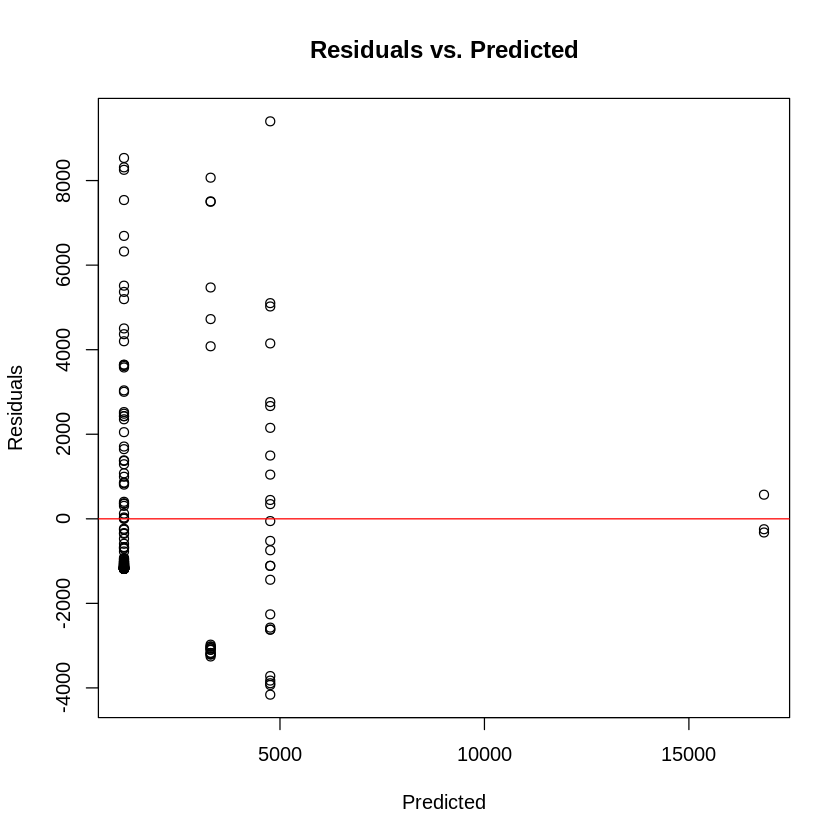

[1] "\nQQ plot of residuals"


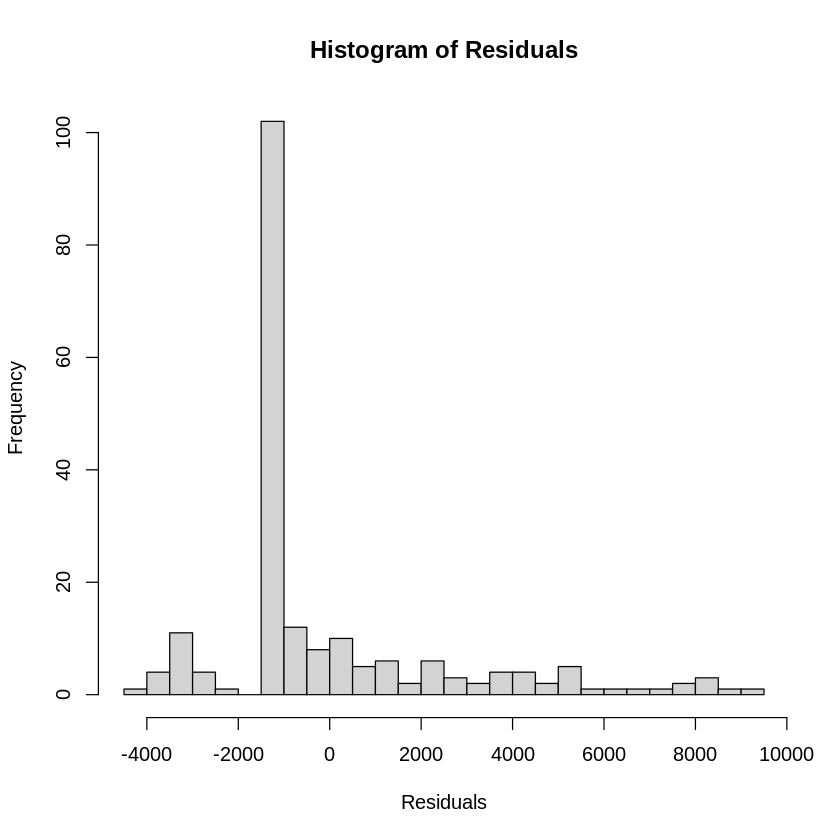

[1] "\nResiduals vs. Fitted Plot:"
[1] "Look for a funnel shape or a pattern suggesting changing variance."
[1] "\nIndependence of Residuals:\n There should be no correlation between consecutive residuals in the data (important in time series data or panel data)."
[1] "Durbin-Watson Test: Tests for autocorrelation of residuals. A Durbin-Watson statistic close to 2 suggests no autocorrelation."


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric





	Durbin-Watson test

data:  lm_model
DW = 0.22914, p-value < 2.2e-16
alternative hypothesis: true autocorrelation is greater than 0



Loading required package: bestglm

Loading required package: leaps

Loading required package: VGAM

Loading required package: stats4

Loading required package: splines


Attaching package: ‘VGAM’


The following object is masked from ‘package:lmtest’:

    lrtest


Loading required package: rpart

Loading required package: randomForest

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine


Important regclass change from 1.3:
All functions that had a . in the name now have an _
all.correlations -> all_correlations, cor.demo -> cor_demo, etc.




[1] "No Multicollinearity: Predictors should not be too highly correlated."
[1] "Variance Inflation Factor (VIF): VIF values greater than 10 (some sources say 5) suggest serious multicollinearity."


ERROR: Error in vif(lm_model): could not find function "vif"


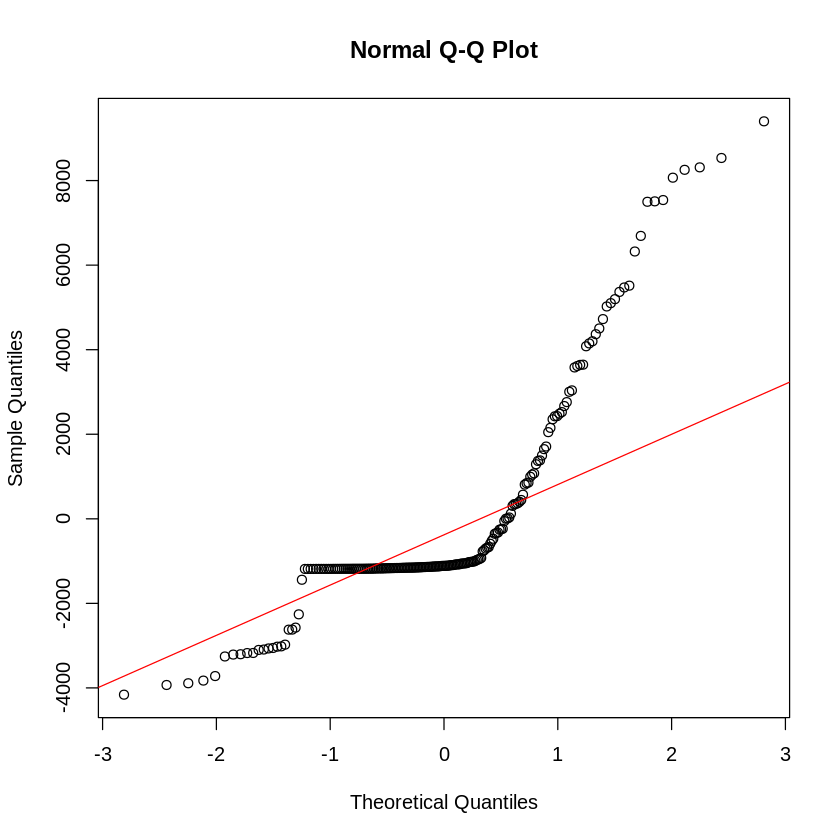

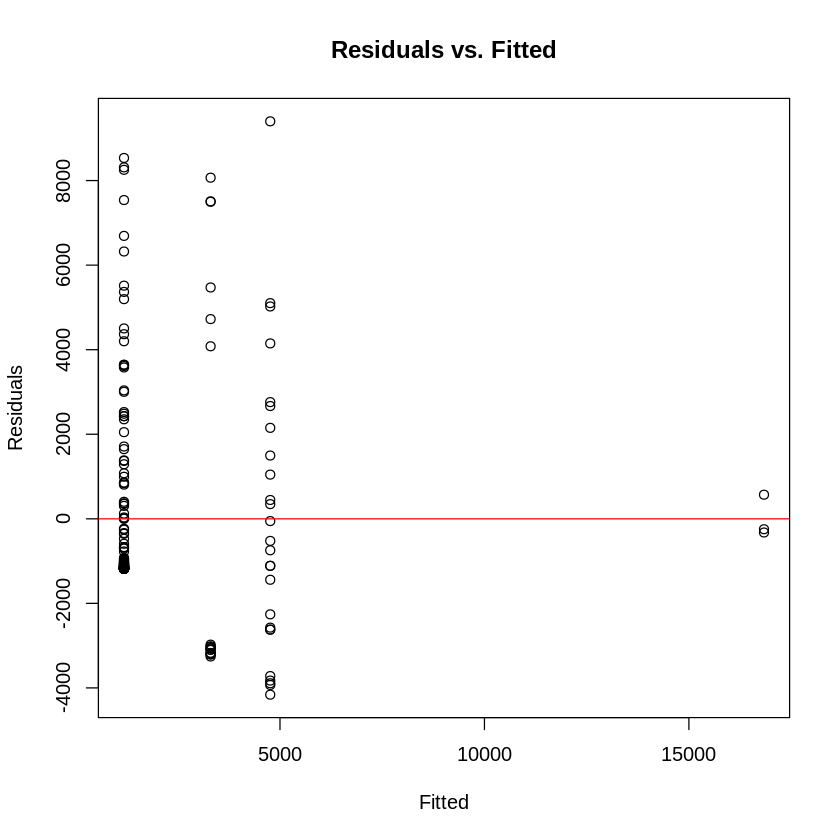

In [16]:
get_lm_assumptions(basic_did)

In [ ]:
get_lm_assumptions(log_basic_did)

In [ ]:
#Modifications and Solutions:
#Correcting Standard Errors: Robust Standard Errors: Use heteroskedasticity and autocorrelation (HAC) robust standard errors. Tools like the Newey-West estimator in R can adjust the standard errors for autocorrelation and potential heteroskedasticity.
install.packages("sandwich")
library(sandwich)
library(lmtest)
coeftest(basic_did, vcov = NeweyWest(basic_did))

# Parallel trend assumptions (Basic DID model)

In [ ]:
aggregated_df <- aggregated_df %>%
  mutate(year_factor = as.factor(year(ref_date)))  # Convert ref_date to year and then to a factor

# Fit the augmented DiD model
augmented_did <- lm(registrations ~ is_quebec * after_policy + is_quebec * year_factor, data = aggregated_df)

# Check the summary for insights into trend differences and policy impact
summary(augmented_did)

results = "The significance of the coefficients for the interaction terms between is_quebec and year_factor \n
prior to the policy implementation provides a formal test of the parallel trends. If these interaction terms \n
are not significantly different from zero, it supports the assumption that trends were parallel before the policy."
cat(results)

In [ ]:
# Event Study Approach
# Assuming `year_relative` is a factor variable for years relative to the treatment year (e.g., -2, -1, 0, 1, ...)
policy_year = 2023
aggregated_df$year_relative = as.factor(year(aggregated_df$ref_date) - policy_year)
str(aggregated_df)

table(aggregated_df$after_policy,aggregated_df$year_relative)
event_study <- lm(registrations ~ after_policy * year_relative, data = aggregated_df)
summary(event_study)

print("Perfect Collinearity:\nFor years -6 to -1, any interaction term involving 'After Policy' (like After Policy:year_relative-X) will be collinear because there is no variation—these years only ever occur 'Before Policy'.
\nThis lack of variability in the after_policy variable for these years is what leads to the NA coefficients in your model for these interaction terms.")

Things to do:

* check linear model assumptions and DID assumptions, make conclusions about assumptions
* add covariates
* introduce mixture

# DID model (mixed): modeling registrations by vehicle type and province

**Base model (mixed)** Registrations$_{i}$ = $\beta_0$+ $\beta_1$* Indicator(is quebec)+ $\beta_2$* Indicator(after policy in effect)+ $\beta_3$* Indicator(is quebec)* Indicator(after policy in effect) + $\beta_4 \cdot$ vehicle_type




**Mixed model:**

mixed_model:

$$
\log(\text{registrations} + 1) = \beta_0 + \beta_1 \cdot \text{Indicator}(\text{is quebec}) + \beta_2 \cdot \text{Indicator}(\text{after policy in effect}) + \beta_3 \cdot \text{Indicator}(\text{is quebec}) \cdot \text{Indicator}(\text{after policy in effect}) +
 u_{\text{province}[j]} + u_{\text{vehicle_type}[k]} + \epsilon_{[ijk]},
$$

$$
u_{\text{province}[j]} \sim \mathcal{N}(0, \sigma^2_{\text{province[j]}})
$$
$$
u_{\text{vehicle_type}[k]} \sim \mathcal{N}(0, \sigma^2_{\text{vehicle_type[k]}})
$$
$$
\epsilon_{[ijk]} \sim  \mathcal{N}(0, \sigma^2)
$$

Where:
- $u_{\text{province}[j]}$ is the random effect for province $j$, accounting for variability in $\log(\text{registrations} + 1)$ that is specific to each province.
- $u_{\text{vehicle_type}[k]}$ is the random effect for vehicle type $k$, accounting for variability that is specific to each vehicle type.
- $\sigma^2_{\text{province[j]}}$ and $\sigma^2_{\text{vehicle_type[k]}}$ are the variances of the random effects for provinces and vehicle types, respectively.


In [ ]:
base_model <- lm(log(registrations+1) ~ is_quebec*after_policy +
                    vehicle_type,
                    data = df_vehicle_type)

summary(base_model)

In [ ]:
head(df_vehicle_type)
install.packages("lme4")

In [ ]:
library(lme4)

# Fit a mixed model with random intercepts for province and vehicle type
mixed_model <- lmer(log(registrations+1) ~ is_quebec*after_policy +
                    vehicle_type + (1 | province) + (1 | vehicle_type),
                    data = df_vehicle_type)

summary(mixed_model)

In [ ]:
# Fit a mixed model with random intercepts for province
mixed_model_province <- lmer(log(registrations+1) ~ is_quebec*after_policy +
                    vehicle_type + (1 | province),
                    data = df_vehicle_type)

summary(mixed_model_province)

In [ ]:
# Fit a mixed model with random intercepts for province
log_mixed_model_province <- lmer(log(registrations+1) ~ is_quebec*after_policy +
                    vehicle_type + (1 | province),
                    data = df_vehicle_type)

summary(log_mixed_model_province)

In [ ]:
# Fit a mixed model with random intercepts for vehicle type
mixed_model_vechicle_type <- lmer(log(registrations+1) ~  is_quebec*after_policy +
                    vehicle_type + (1 | vehicle_type),
                    data = df_vehicle_type)

summary(mixed_model_vechicle_type)

In [ ]:
# Fit a mixed model with random intercepts for vehicle type
mixed_model_vechicle_type_province <- lmer(log(registrations+1) ~  is_quebec*after_policy +
                    vehicle_type + (1 | vehicle_type:province),
                    data = df_vehicle_type)

summary(mixed_model_vechicle_type_province)

In [ ]:
# Compare models
AIC(base_model, mixed_model_vechicle_type_province)
AIC(base_model, mixed_model_province)
AIC(base_model, mixed_model_vechicle_type)

In [ ]:
install.packages("lmtest")
library(lmtest)
bptest(mixed_model_province)  # Breusch-Pagan test on the original model
bptest(log_mixed_model_province)  # On the log-transformed model

In [ ]:
  print("\nQQ plot of residuals: base_model")
  qqnorm(residuals(base_model))
  qqline(residuals(base_model), col = "red") #normal should look like this

  print("\nQQ plot of residuals: mixed_model_province")
  qqnorm(residuals(mixed_model_province))
  qqline(residuals(mixed_model_province), col = "red") #normal should look like this


In [ ]:

  print("\nQQ plot of residuals: base_model")
  qqnorm(residuals(base_model))
  qqline(residuals(base_model), col = "red") #normal should look like this

  print("\nQQ plot of residuals: log_mixed_model_province")
  qqnorm(residuals(log_mixed_model_province))
  qqline(residuals(log_mixed_model_province), col = "red") #normal should look like this

  print("\nQQ plot of residuals: mixed_model_vechicle_type")
  qqnorm(residuals(mixed_model_vechicle_type))
  qqline(residuals(mixed_model_vechicle_type), col = "red") #normal should look like this


In [ ]:
plot(residuals(base_model) ~ fitted(base_model))
plot(residuals(mixed_model_vechicle_type_province) ~ fitted(mixed_model_vechicle_type_province))

In [ ]:
library(lme4)
# Example using bootMer to perform a parametric bootstrap
set.seed(123)
cv_model1 <- bootMer(mixed_model_vechicle_type_province, FUN = function(x) fixef(x), nsim = 100)
cv_model2 <- bootMer(mixed_model_province, FUN = function(x) fixef(x), nsim = 100)
cv_model3 <- bootMer(mixed_model, FUN = function(x) fixef(x), nsim = 100)
cv_model4 <- bootMer(mixed_model_vechicle_type, FUN = function(x) fixef(x), nsim = 100)

cv_model1
cv_model2
cv_model3
cv_model4

# Staggered difference-in-difference method

# Machine learning with DiD

pretty confused right now. to-do: read this https://arxiv.org/pdf/1608.00060

Just a fancy way of completing the following steps:

**stage 1: model the treatment assignment process and estimate the target (aka. outcome) variable from covariate alone (on the k-1 folds):**

  1. model 1: estimate the probability of getting assigned a treatment (binary in our case, i.e. "is_quebec" variable) based on covariate alone (excluding the indicator variable of the treatment and that of the policy-in-effect) -> use model 1 to calculate if the treatment (policy) will be assigned to each record, based on the covariate alone

  2. model 2: esitmate the target variable (i.e. registration count) against covariate alone (both on treatment =0 and treatment =1 data slices) -> use model 2 to estimate the registration count alone

**stage 2: compute the residuals from stage 1 of the target variable's fit on data from the k-th fold.**

  1. estimate the target variable both before and after the treatment (e.g. hold treatment =0 and hold it = 1, respectively) by using model_1 to predict "is_quebec" and model_2 to predict "registrations".

  2. log(registrations + 1) - is_quebec * pred_outcome_after - (1 - is_quebec) * pred_outcome_before. **why?**


Very similar to the frequency and severity model in insurance, not gonna lie.. any needs to model the dependency between the two outcomes (e.g. copula..)

why not use transformer? any what situations ML outperforms simple lm DiD? high-dimensional covariates?


Note: personally, I don't think stage 1 makes sense, because the policy decision may be a pilot or an arbitrary decision that has little to do with covariates. in this case, the misclassification matrix could be ridiculous.

E.g. government in Canada mimicks other countries like the US and Australia, to see if certain intervention works and the size of impact (e.g. average treatment effect).


In [18]:
install.packages("caret")
library(caret)

propensity_model <- train(is_quebec ~ vehicle_type, data = df_vehicle_type, method = "glm", family = "binomial") #swap with svm
df_vehicle_type$propensity_score <- predict(propensity_model, df_vehicle_type, type = "prob")[,2] #swap with svm

outcome_model_before <- train(log(registrations + 1) ~ vehicle_type, data = subset(df_vehicle_type, after_policy == 0), method = "rf") #why neglect the other
outcome_model_after <- train(log(registrations + 1) ~ vehicle_type, data = subset(df_vehicle_type, after_policy == 1), method = "rf")

df_vehicle_type$pred_outcome_before <- predict(outcome_model_before, df_vehicle_type)
df_vehicle_type$pred_outcome_after <- predict(outcome_model_after, df_vehicle_type)

# This example uses a simple cross-fitting approach with two folds
set.seed(123)
folds <- createFolds(df_vehicle_type$is_quebec, k = 2)

results <- lapply(folds, function(fold) {
  train_data <- df_vehicle_type[-fold,]
  test_data <- df_vehicle_type[fold,]

  # Fit propensity and outcome models on the training data
  propensity_model <- train(is_quebec ~ vehicle_type, data = train_data, method = "glm", family = "binomial")
  outcome_model_before <- train(log(registrations + 1) ~ vehicle_type, data = subset(train_data, after_policy == 0), method = "rf")
  outcome_model_after <- train(log(registrations + 1) ~ vehicle_type, data = subset(train_data, after_policy == 1), method = "rf")

  # Predict on the test data
  test_data$propensity_score <- predict(propensity_model, test_data, type = "prob")[,2]
  test_data$pred_outcome_before <- predict(outcome_model_before, test_data)
  test_data$pred_outcome_after <- predict(outcome_model_after, test_data)

  # Orthogonalized score calculation
  test_data$residual <- with(test_data, log(registrations + 1) - (is_quebec * after_policy * (pred_outcome_after - pred_outcome_before)) / propensity_score)

  return(mean(test_data$residual))
})

# Average the results from cross-fitting
average_treatment_effect <- mean(unlist(results))


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Loading required package: lattice


Attaching package: ‘lattice’


The following object is masked from ‘package:regclass’:

    qq



Attaching package: ‘caret’


The following object is masked from ‘package:VGAM’:

    predictors




ERROR: Error: Every row has at least one missing value were found


See other notebook

literature: https://academic.oup.com/ectj/article/23/2/177/5722119

# What makes Quebec rebate better than Ontario's? How to tweak policies to make them more effective?